# Rich-Get-Richer Model: The Unpredictability of Popularity

This notebook implements a rich-get-richer model (commonly known as preferential attachment) to analyze the emergence of power law degree distributions in complex networks. We investigate how popularity dynamics in networks can be quantified and why they often exhibit inherent unpredictability despite deterministic growth mechanisms.

## Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
from collections import Counter
import random

# Set the random seed for reproducibility
np.random.seed(42)
random.seed(42)

## Define the Model with Random and Copying Mechanisms

Our model creates networks where new nodes connect to existing nodes through two mechanisms:

1. **Random Attachment**: With probability $p$, a new node connects to a random existing node.
2. **Copying Mechanism**: With probability $1-p$, a new node first randomly selects an existing node and then connects to one of its neighbors (copying its connection pattern).

This copying mechanism produces a rich-get-richer effect implicitly, because nodes with higher degree are more likely to be selected as neighbors. When $p=0$, we have pure copying. When $p=1$, we have pure random attachment.

In [2]:
def initialize_network(n0=5):
    """
    Initialize a network with n0 nodes, fully connected.
    
    Parameters:
    -----------
    n0 : int
        The number of initial nodes in the network
        
    Returns:
    --------
    G : networkx.Graph
        The initialized network
    node_creation_time : dict
        Dictionary mapping node IDs to their creation time
    """
    G = nx.complete_graph(n0)
    node_creation_time = {i: 0 for i in range(n0)}
    
    return G, node_creation_time

def copying_model(G, n_steps, m=1, p=0.0):
    """
    Grow a network using a mixed model of random attachment and copying mechanism.
    
    Parameters:
    -----------
    G : networkx.Graph
        The initial network
    n_steps : int
        Number of nodes to add
    m : int
        Number of edges each new node creates
    p : float
        Probability of random attachment (1-p is the probability of copying mechanism)
        
    Returns:
    --------
    G : networkx.Graph
        The grown network
    node_creation_time : dict
        Dictionary mapping node IDs to their creation time
    """
    node_creation_time = {i: 0 for i in G.nodes()}
    
    # Start adding new nodes
    for t in range(n_steps):
        new_node = len(G.nodes())
        node_creation_time[new_node] = t + 1
        
        # Add the new node
        G.add_node(new_node)
        
        # Connect m edges from the new node to existing nodes
        existing_nodes = list(G.nodes())[:-1]  # All nodes except the new one
        edges_added = 0
        
        while edges_added < min(m, len(existing_nodes)):
            # Decide whether to use random or copying mechanism
            if random.random() < p:  # Random attachment
                # Choose a random target node
                target_candidates = [node for node in existing_nodes if not G.has_edge(new_node, node)]
                if not target_candidates:
                    break  # No more candidates available
                    
                target = random.choice(target_candidates)
            else:  # Copying mechanism
                # First, randomly select an existing node
                random_node = random.choice(existing_nodes)
                
                # Get neighbors of the randomly selected node
                neighbors = list(G.neighbors(random_node))
                
                # If the random node has no neighbors or all neighbors are already connected to new_node
                if not neighbors or all(G.has_edge(new_node, neighbor) for neighbor in neighbors):
                    # Fall back to random attachment
                    target_candidates = [node for node in existing_nodes if not G.has_edge(new_node, node)]
                    if not target_candidates:
                        break  # No more candidates available
                    target = random.choice(target_candidates)
                else:
                    # Filter out neighbors already connected to the new node
                    valid_neighbors = [n for n in neighbors if not G.has_edge(new_node, n)]
                    if not valid_neighbors:
                        continue  # Try again with a different random node
                        
                    # Choose a random neighbor to connect to (copying the connection)
                    target = random.choice(valid_neighbors)
            
            # Add the edge
            G.add_edge(new_node, target)
            edges_added += 1
        
    return G, node_creation_time

## Simulate the Model

Now we'll run the model for a specific number of iterations. We'll use a mixture of random and preferential attachment.

In [3]:
# Parameters
n0 = 5         # Initial number of nodes
n_steps = 995  # Number of nodes to add (total will be n0 + n_steps)
m = 2          # Number of edges each new node creates
p = 0.2        # Probability of random attachment (1-p = 0.8 for copying mechanism)

# Initialize the network
G, node_creation_time = initialize_network(n0)

# Grow the network using the copying model
G, node_creation_time = copying_model(G, n_steps, m, p)

print(f"Final network has {len(G.nodes())} nodes and {len(G.edges())} edges")

Final network has 1000 nodes and 2000 edges


## Visualize the Results

Let's first look at the degree distribution of the resulting network. In a copying model, we expect to see a power-law degree distribution (a straight line on a log-log plot) similar to preferential attachment, as copying implicitly creates a rich-get-richer effect.

Calculating best minimal value for power law fit
Estimated xmin: 5.0
Estimated alpha: 2.7299434469502772


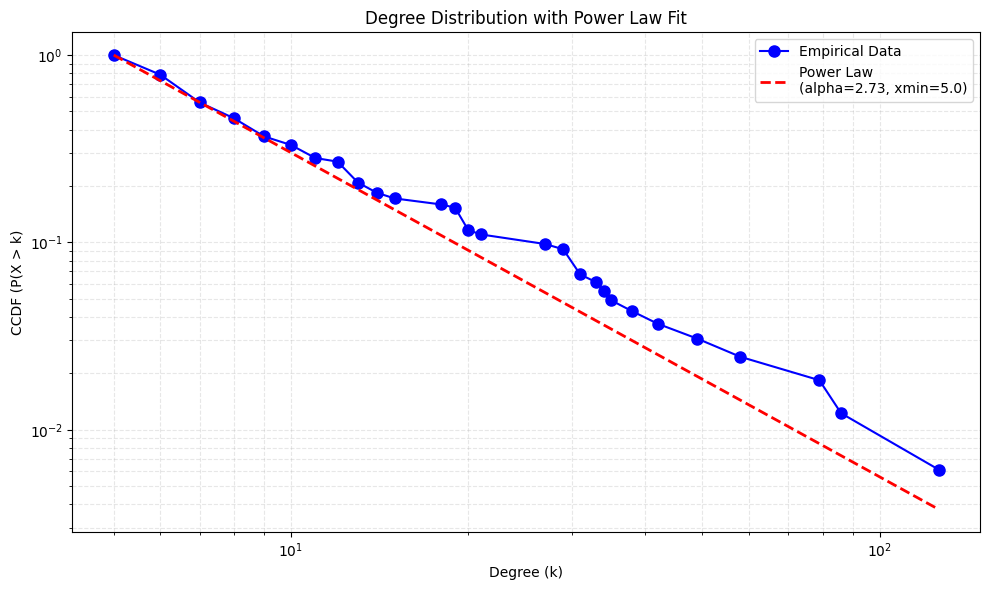

In [4]:
import powerlaw

degrees = [d for _, d in G.degree()]

# Fit the degree distribution using powerlaw.Fit
fit = powerlaw.Fit(degrees)
print("Estimated xmin:", fit.power_law.xmin)
print("Estimated alpha:", fit.power_law.alpha)

# Plot the empirical PDF and the power-law fit
fig, ax = plt.subplots(figsize=(10, 6))
fit.plot_ccdf(color='b', marker='o', markersize=8, label='Empirical Data', ax=ax)
fit.power_law.plot_ccdf(color='r', linestyle='--', linewidth=2, label=f'Power Law\n(alpha={fit.power_law.alpha:.2f}, xmin={fit.power_law.xmin})', ax=ax)

plt.xlabel('Degree (k)')
plt.ylabel('CCDF (P(X > k)')
plt.title('Degree Distribution with Power Law Fit')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()


## Analyze Popularity Distribution

Now, let's examine the distribution of popularity (node degrees) and compare the "winners" (nodes with highest degrees) to their arrival time. This will help us understand if early nodes always win or if there's unpredictability in the system.

In [5]:
# Create a DataFrame to analyze node properties
node_data = pd.DataFrame({
    'node_id': list(G.nodes()),
    'degree': [G.degree(node) for node in G.nodes()],
    'creation_time': [node_creation_time[node] for node in G.nodes()]
})

# Sort by degree (popularity) in descending order
node_data_sorted = node_data.sort_values('degree', ascending=False).reset_index(drop=True)

# Look at the top 20 most popular nodes
print("Top 20 nodes with highest degrees:")
print(node_data_sorted.head(20))

Top 20 nodes with highest degrees:
    node_id  degree  creation_time
0         3     126              0
1         1      86              0
2        12      79              8
3         0      58              0
4         6      49              2
5        19      42             15
6        18      38             14
7        77      35             73
8       106      34            102
9         4      33              0
10       37      31             33
11       36      29             32
12      141      29            137
13       21      29             17
14        8      29              4
15       11      27              7
16       31      21             27
17       92      21             88
18      231      20            227
19       46      19             42


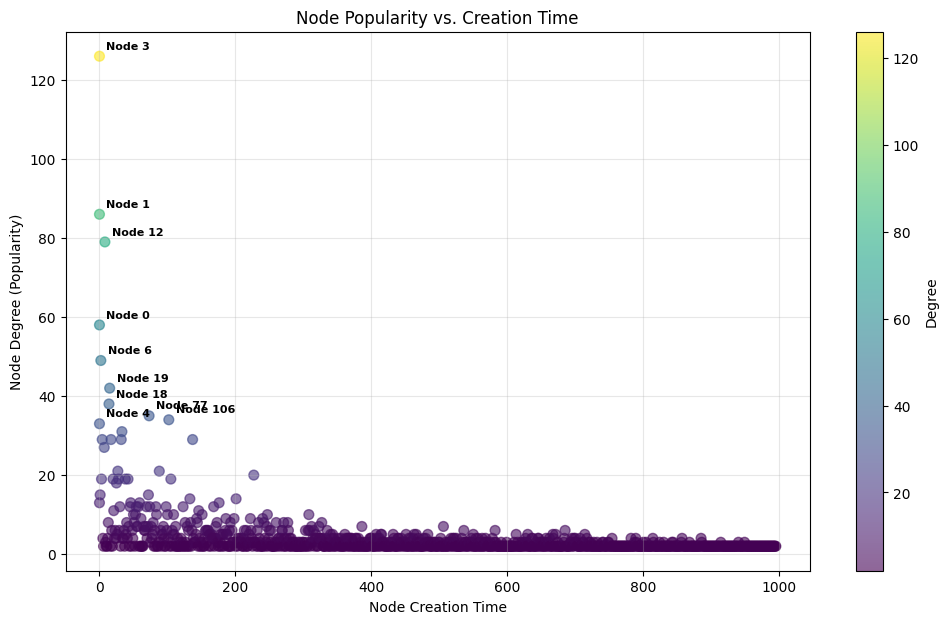

In [6]:
# Create a scatter plot of degree vs. creation time
plt.figure(figsize=(12, 7))
plt.scatter(node_data['creation_time'], node_data['degree'], 
            alpha=0.6, s=50, c=node_data['degree'], cmap='viridis')

# Add labels for the top 10 nodes by degree
top_nodes = node_data_sorted.head(10)
for i, row in top_nodes.iterrows():
    plt.annotate(f"Node {row['node_id']}", 
                 xy=(row['creation_time'], row['degree']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=8, fontweight='bold')

plt.xlabel('Node Creation Time')
plt.ylabel('Node Degree (Popularity)')
plt.title('Node Popularity vs. Creation Time')
plt.colorbar(label='Degree')
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Let's analyze the "first-mover advantage"
# Compare the average degree of the first n0 nodes with the average degree of all nodes
first_movers = node_data[node_data['creation_time'] == 0]
others = node_data[node_data['creation_time'] > 0]

print(f"Average degree of initial {n0} nodes: {first_movers['degree'].mean():.2f}")
print(f"Average degree of all other nodes: {others['degree'].mean():.2f}")
print(f"Ratio: {first_movers['degree'].mean() / others['degree'].mean():.2f}x")

# Calculate what percentage of the top 10% nodes by degree were early nodes
top_10_percent = int(len(node_data) * 0.1)
top_nodes = node_data_sorted.head(top_10_percent)
early_in_top = sum(top_nodes['creation_time'] == 0)
print(f"\nNumber of initial nodes in top 10% by degree: {early_in_top} out of {len(first_movers)}")
print(f"Percentage of initial nodes that made it to top 10%: {early_in_top/len(first_movers)*100:.1f}%")

Average degree of initial 5 nodes: 63.20
Average degree of all other nodes: 3.70
Ratio: 17.07x

Number of initial nodes in top 10% by degree: 5 out of 5
Percentage of initial nodes that made it to top 10%: 100.0%


## Interpretation of Results

Let's analyze the unpredictability of popularity by running multiple simulations and tracking specific nodes across these simulations.

### Coefficient of Variation (CV)

To measure the unpredictability of node popularity quantitatively, we'll use the **Coefficient of Variation (CV)**. The CV is a standardized measure of dispersion that allows us to compare variability across different scales.

**Definition:** $CV = \frac{\sigma}{\mu}$ where $\sigma$ is the standard deviation and $\mu$ is the mean.

**Interpretation:**
- **CV = 0**: No variation (perfect predictability)
- **CV < 0.1**: Very low variation
- **CV 0.1-0.2**: Low variation
- **CV 0.2-0.3**: Moderate variation
- **CV > 0.3**: High variation
- **CV > 1.0**: Extremely high variation (standard deviation exceeds the mean)

When applied to node rank or degree across multiple simulations, a high CV indicates that a node's popularity is highly unpredictable, while a low CV suggests more consistent outcomes. By comparing CVs across different nodes and groups of nodes, we can quantify which nodes are most subject to randomness and evaluate how unpredictability varies with factors like node age.

In [8]:
def run_multiple_simulations(num_sims=50, n0=5, n_steps=995, m=2, p=0.2):
    """Run multiple simulations and track node degrees"""
    results = []
    
    for sim in range(num_sims):
        # Set a different random seed for each simulation
        random.seed(42 + sim)
        np.random.seed(42 + sim)
        
        # Initialize and grow the network
        G, node_creation_time = initialize_network(n0)
        G, node_creation_time = copying_model(G, n_steps, m, p)
        
        # Store the results
        result = {
            'simulation': sim,
            'node_id': list(G.nodes()),
            'degree': [G.degree(node) for node in G.nodes()],
            'creation_time': [node_creation_time[node] for node in G.nodes()]
        }
        
        # Convert to DataFrame and append
        results.append(pd.DataFrame(result))
    
    # Combine all simulations
    all_results = pd.concat(results, ignore_index=True)
    return all_results

# Run multiple simulations
print("Running multiple simulations to analyze unpredictability...")
simulation_results = run_multiple_simulations(num_sims=50)
print(f"Completed {len(simulation_results['simulation'].unique())} simulations")

Running multiple simulations to analyze unpredictability...
Completed 50 simulations


In [9]:
# Let's analyze the unpredictability of node popularity across all simulations

# First, let's calculate rank correlation across simulations
# For each node, get its popularity rank in each simulation
def calculate_rank_variability(sim_results, n0=5):
    # Group by simulation and get ranks within each simulation (lower rank = higher degree)
    sim_results['rank'] = sim_results.groupby('simulation')['degree'].rank(ascending=False)
    
    # Calculate statistics about rank across simulations for each node
    node_rank_stats = sim_results.groupby('node_id').agg({
        'rank': ['mean', 'std', 'min', 'max'],
        'degree': ['mean', 'std', 'min', 'max'],
        'creation_time': 'first'  # Just to keep track of when the node was created
    })
    
    # Flatten column names
    node_rank_stats.columns = ['_'.join(col).strip() for col in node_rank_stats.columns.values]
    node_rank_stats = node_rank_stats.reset_index()
    
    # Calculate coefficient of variation for ranks (higher = more variable ranking)
    node_rank_stats['rank_cv'] = node_rank_stats['rank_std'] / node_rank_stats['rank_mean']
    node_rank_stats['degree_cv'] = node_rank_stats['degree_std'] / node_rank_stats['degree_mean']
    
    # Sort by mean rank and reset index
    return node_rank_stats.sort_values('rank_mean').reset_index(drop=True)

# Calculate rank variability metrics
rank_stats = calculate_rank_variability(simulation_results)

# Print summary statistics
print("\nUnpredictability Analysis of Node Popularity:")
print(f"Average Coefficient of Variation (CV) of ranks: {rank_stats['rank_cv'].mean():.3f}")
print(f"Average Coefficient of Variation (CV) of degrees: {rank_stats['degree_cv'].mean():.3f}")

# Show the nodes with highest rank variability (top 10)
most_variable = rank_stats.sort_values('rank_cv', ascending=False).head(10)
print("\nTop 10 nodes with highest rank variability:")
print(most_variable[['node_id', 'creation_time_first', 'rank_mean', 'rank_std', 'rank_cv']])

# Compare early vs. late nodes in terms of rank variability
early_nodes = rank_stats[rank_stats['creation_time_first'] <= n0*2]
late_nodes = rank_stats[rank_stats['creation_time_first'] > n0*2]
print("\nRank Variability by Node Age:")
print(f"Early nodes (first {len(early_nodes)}) mean rank CV: {early_nodes['rank_cv'].mean():.3f}")
print(f"Later nodes (remaining {len(late_nodes)}) mean rank CV: {late_nodes['rank_cv'].mean():.3f}")


Unpredictability Analysis of Node Popularity:
Average Coefficient of Variation (CV) of ranks: 0.502
Average Coefficient of Variation (CV) of degrees: 0.433

Top 10 nodes with highest rank variability:
    node_id  creation_time_first  rank_mean    rank_std   rank_cv
6         7                    3      59.30  143.086708  2.412929
3         3                    0      13.40   28.180359  2.103012
7         5                    1      65.60  125.526077  1.913507
4         1                    0      14.22   27.131231  1.907963
12       12                    8     110.84  210.403583  1.898264
0         2                    0       7.99   14.765338  1.847977
5         6                    2      54.91   97.592274  1.777313
2         0                    0      12.03   21.135957  1.756937
8        11                    7      86.62  151.686255  1.751169
9        16                   12      99.06  169.771414  1.713824

Rank Variability by Node Age:
Early nodes (first 15) mean rank CV: 1.77

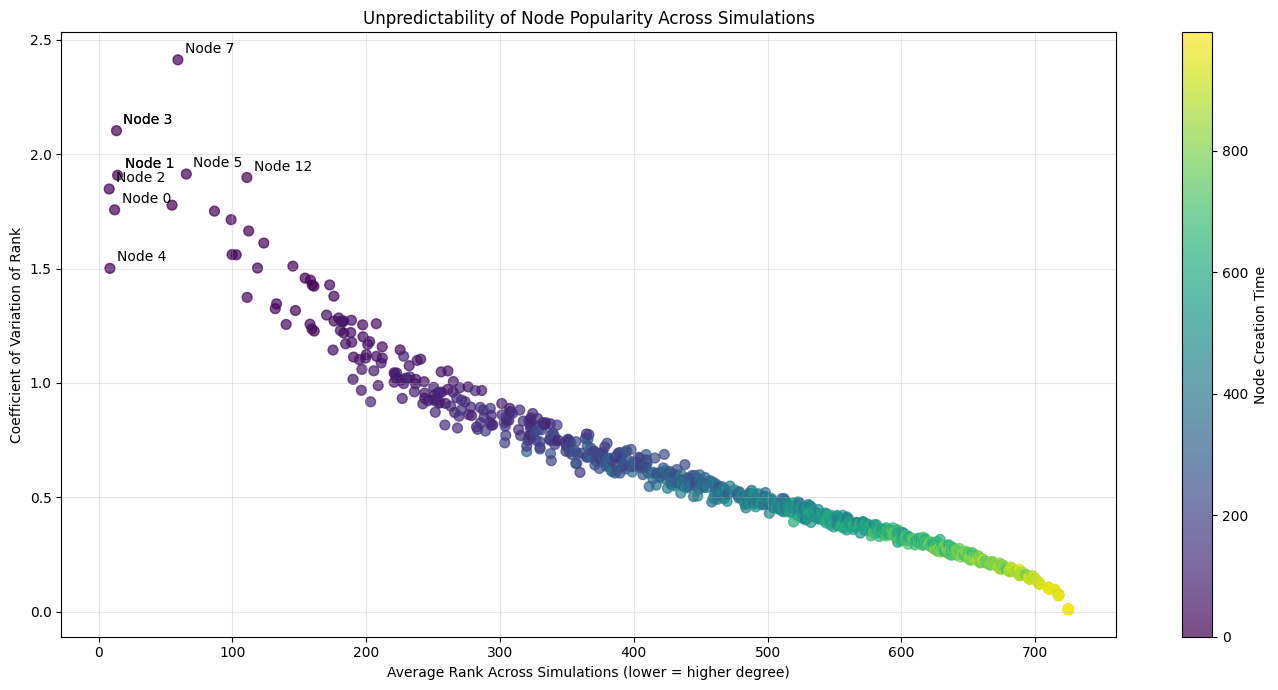

In [10]:
# Visualize rank variability across all nodes
plt.figure(figsize=(14, 7))

# Plot rank coefficient of variation vs. average rank
plt.scatter(rank_stats['rank_mean'], rank_stats['rank_cv'], 
            c=rank_stats['creation_time_first'], cmap='viridis', 
            s=50, alpha=0.7)

# Label some interesting points (most variable and top-ranked nodes)
for _, node in pd.concat([most_variable.head(5), rank_stats.head(5)]).iterrows():
    plt.annotate(f"Node {int(node['node_id'])}",
                 xy=(node['rank_mean'], node['rank_cv']),
                 xytext=(5, 5), textcoords='offset points')

plt.colorbar(label='Node Creation Time')
plt.xlabel('Average Rank Across Simulations (lower = higher degree)')
plt.ylabel('Coefficient of Variation of Rank')
plt.title('Unpredictability of Node Popularity Across Simulations')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# Select nodes from different time periods with highest rank variability
def select_sample_nodes(rank_stats, n_samples=5):
    total_nodes = len(rank_stats)
    
    # Identify nodes from different periods
    early_nodes = rank_stats[rank_stats['creation_time_first'] <= total_nodes * 0.1]
    middle_nodes = rank_stats[(rank_stats['creation_time_first'] > total_nodes * 0.1) & 
                        (rank_stats['creation_time_first'] <= total_nodes * 0.5)]
    late_nodes = rank_stats[rank_stats['creation_time_first'] > total_nodes * 0.5]
    
    # Select the n_samples nodes with highest rank variability from each period
    early_varied = early_nodes.sort_values('rank_cv', ascending=False).head(n_samples)
    middle_varied = middle_nodes.sort_values('rank_cv', ascending=False).head(n_samples)
    late_varied = late_nodes.sort_values('rank_cv', ascending=False).head(n_samples)
    
    # Combine the selections
    return pd.concat([early_varied, middle_varied, late_varied])

# Get sample nodes with highest variability
sample_nodes = select_sample_nodes(rank_stats)

# Extract degree data for these sample nodes across all simulations
sample_data = simulation_results[simulation_results['node_id'].isin(sample_nodes['node_id'])].copy()

# Add period information using a helper function
def get_period(creation_time, total_nodes=1000):
    if creation_time <= total_nodes * 0.1:
        return 'Early'
    elif creation_time <= total_nodes * 0.5:
        return 'Middle'
    else:
        return 'Late'

sample_data['period'] = sample_data['creation_time'].apply(get_period)



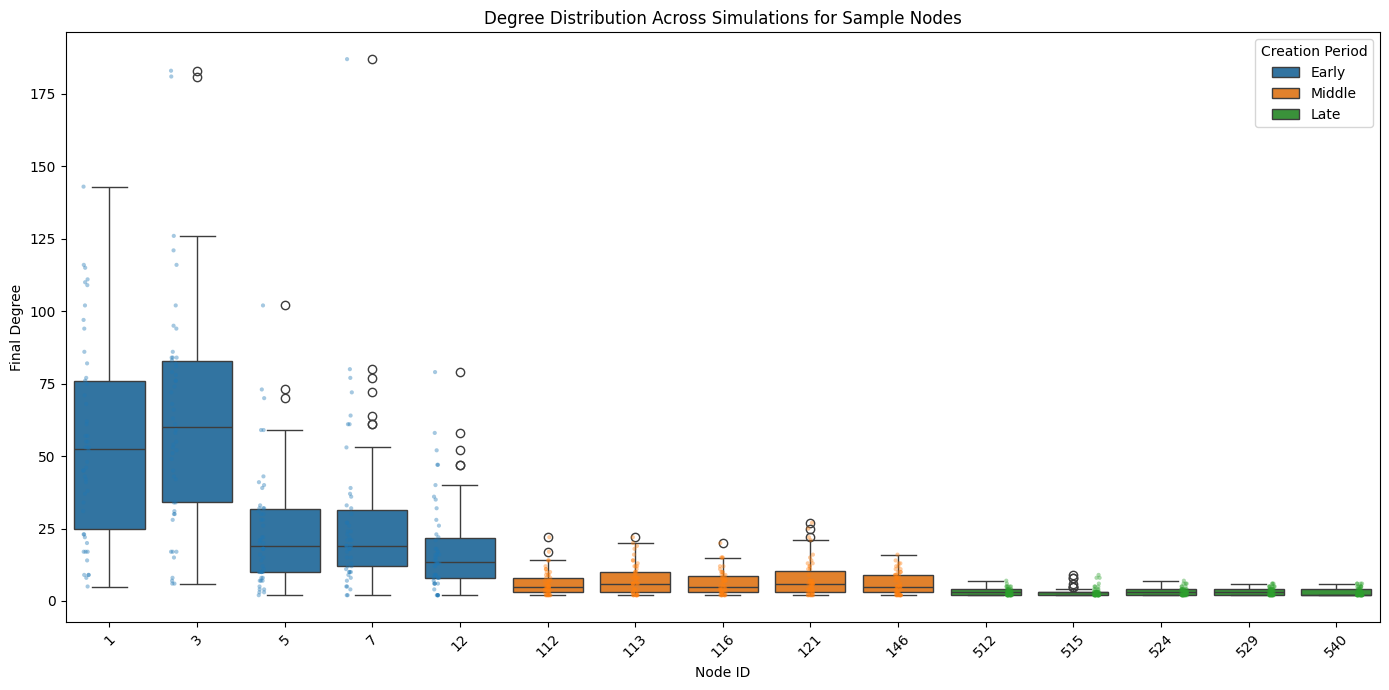

In [12]:
# Create a boxplot to show degree distributions by node
plt.figure(figsize=(14, 7))
ax = sns.boxplot(x='node_id', y='degree', hue='period', data=sample_data)

# Add stripplot to show individual data points
sns.stripplot(x='node_id', y='degree', hue='period', data=sample_data, 
              dodge=True, alpha=0.4, size=3)

# Improve the plot
plt.title('Degree Distribution Across Simulations for Sample Nodes')
plt.xlabel('Node ID')
plt.ylabel('Final Degree')
plt.xticks(rotation=45)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:3], labels[:3], title='Creation Period')
plt.tight_layout()
plt.show()

## Conclusion: The Unpredictability of Popularity

Our simulations of the rich-get-richer model demonstrate several key insights about popularity dynamics in complex networks:

1. **Power Law Distribution**: The degree distribution follows a power law, with few nodes having very high degrees (becoming "popular") and most nodes having low degrees, creating a highly unequal distribution of popularity.

2. **First-Mover Advantage**: Early nodes generally have an advantage and tend to accumulate more connections than later nodes. This is evident from the higher average degree of initial nodes compared to nodes that joined later.

3. **Unpredictability**: Despite the first-mover advantage, there's substantial unpredictability in which specific nodes become the most popular. Across our simulations, different nodes emerged as "winners," and even early nodes showed considerable variability in their final popularity.

4. **Randomness in Success**: The model demonstrates how some inherent randomness in early connections can be amplified by the preferential attachment mechanism, leading to different outcomes in each simulation.

This unpredictability mirrors real-world phenomena where success is influenced by both timing (early entry) and chance events, especially in the early stages. For example, in social media, similar content may achieve vastly different levels of popularity based on small initial differences that get amplified through preferential attachment processes.

The rich-get-richer model thus provides a mathematical basis for understanding the combination of deterministic forces (preferential attachment) and random processes that shape popularity in many complex systems.